In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, NamedTuple, Tuple

In [26]:
results = pd.read_csv('../results/processed_data.csv')
results.head()

,timestamp,user_id,day,quiz_id,image_index,illusion_filename,user_answer,response_time,speed_group,display_time,correct_answer,line_length1,line_length2,actual_difference,arrow_length,angle,arrow_color,is_control,is_correct
0,2024-11-04 21:33:40,mattrau1,1,2,0,muller_lyer_day1_illusion25.svg,Left,8.259,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,False
1,2024-11-04 21:33:41,jonah.harmon,1,0,0,muller_lyer_day1_illusion4.svg,Left,4.777,Group 1 - Fast,0.5,Same length,180,180,0,20,36,black,False,False
2,2024-11-04 21:33:44,mattrau1,1,2,1,muller_lyer_day1_illusion30.svg,Left,2.741,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,False
3,2024-11-04 21:33:45,jonah.harmon,1,0,1,muller_lyer_day1_illusion11.svg,Same length,2.907,Group 1 - Fast,0.5,Same length,205,205,0,20,36,red,False,True
4,2024-11-04 21:33:47,mwhite,1,2,0,muller_lyer_day1_illusion25.svg,Same length,3.467,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,True


In [27]:
class ParticipantStats(NamedTuple):
    user_id: str
    total_trials: int
    correct_black: int
    total_black: int
    correct_red: int
    total_red: int
    avg_rt_fast: float
    avg_rt_slow: float
    correct_fast: int
    total_fast: int
    correct_slow: int
    total_slow: int

In [28]:
def calculate_participant_stats(df: pd.DataFrame) -> Dict[str, ParticipantStats]:
    """Calculate statistics for each participant."""
    stats = {}
    
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id]
        
        # Calculate color-based stats
        black_trials = user_data[user_data['arrow_color'] == 'black']
        red_trials = user_data[user_data['arrow_color'] == 'red']
        
        # Calculate speed-based stats
        fast_trials = user_data[user_data['speed_group'].str.contains('Fast')]
        slow_trials = user_data[user_data['speed_group'].str.contains('Slow')]
        
        stats[user_id] = ParticipantStats(
            user_id=user_id,
            total_trials=len(user_data),
            correct_black=len(black_trials[black_trials['is_correct']]),
            total_black=len(black_trials),
            correct_red=len(red_trials[red_trials['is_correct']]),
            total_red=len(red_trials),
            avg_rt_fast=fast_trials['response_time'].mean(),
            avg_rt_slow=slow_trials['response_time'].mean(),
            correct_fast=len(fast_trials[fast_trials['is_correct']]),
            total_fast=len(fast_trials),
            correct_slow=len(slow_trials[slow_trials['is_correct']]),
            total_slow=len(slow_trials)
        )
    
    return stats

In [29]:
def create_comparison_visualization(stats: Dict[str, ParticipantStats]) -> None:
    """Create a visualization comparing fast vs slow performance."""
    # Prepare data for plotting
    plot_data = []
    
    for stat in stats.values():
        # Only include data points where trials exist
        if stat.total_fast > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Fast',
                'Accuracy (%)': (stat.correct_fast / stat.total_fast * 100)
            })
        if stat.total_slow > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Slow',
                'Accuracy (%)': (stat.correct_slow / stat.total_slow * 100)
            })
    
    plot_data = pd.DataFrame(plot_data)
    
    if len(plot_data) == 0:
        print("Warning: No data available for visualization")
        return
    
    # Create the visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create box plot with individual points
    sns.boxplot(data=plot_data, x='Speed', y='Accuracy (%)', color='lightgray')
    sns.swarmplot(data=plot_data, x='Speed', y='Accuracy (%)', color='darkblue', size=8)
    
    # Customize the plot
    plt.title('Accuracy Comparison: Fast vs Slow Display Times', pad=20)
    plt.ylabel('Accuracy (%)')
    
    # Add mean lines for each condition
    means = plot_data.groupby('Speed')['Accuracy (%)'].mean()
    for i, speed in enumerate(means.index):
        plt.hlines(means[speed], i-0.3, i+0.3, color='red', linestyles='dashed', label='Mean' if i == 0 else '')
    
    plt.legend()
    plt.tight_layout()

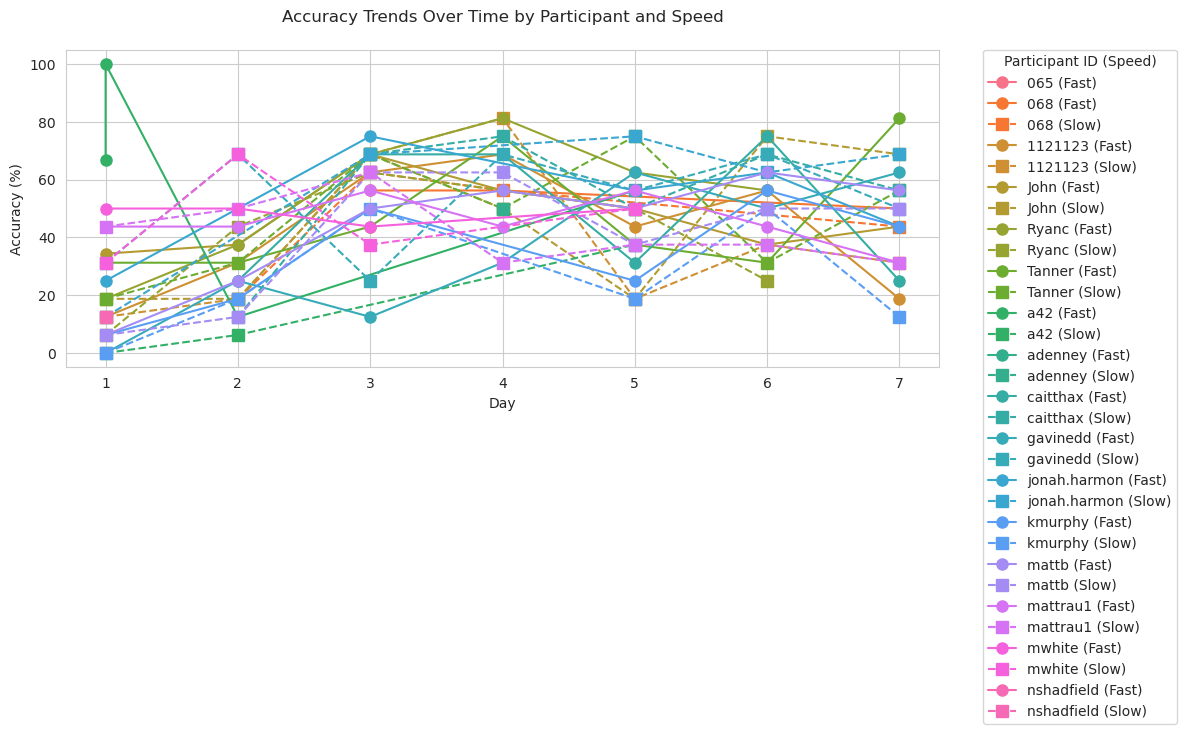

In [30]:
def create_accuracy_trend_visualization(df: pd.DataFrame, users_to_include: list = None) -> None:
    """
    Create a line plot showing accuracy trends over days for selected participants, separated by speed.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    users_to_include : list, optional
        List of user IDs to include in the visualization. If None, includes all users.
    """
    # Filter for specified users if provided
    if users_to_include is not None:
        df = df[df['user_id'].isin(users_to_include)]
        if df.empty:
            print("No data found for specified users.")
            return
    
    # Calculate daily accuracy for each participant and speed condition
    daily_accuracy = df.groupby(['user_id', 'day', 'speed_group']).agg({
        'is_correct': ['count', 'sum']
    }).reset_index()
    
    # Calculate accuracy percentage
    daily_accuracy.columns = ['user_id', 'day', 'speed_group', 'total_trials', 'correct_trials']
    daily_accuracy['accuracy'] = (daily_accuracy['correct_trials'] / 
                                daily_accuracy['total_trials'] * 100)
    
    # Simplify speed group names
    daily_accuracy['speed'] = daily_accuracy['speed_group'].apply(
        lambda x: 'Fast' if 'Fast' in x else 'Slow'
    )
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Get unique users for color assignment
    users = sorted(df['user_id'].unique())
    colors = sns.color_palette("husl", n_colors=len(users))
    
    # Create line plot for each user and speed condition
    for i, user in enumerate(users):
        user_data = daily_accuracy[daily_accuracy['user_id'] == user]
        
        # Plot fast condition (solid line)
        fast_data = user_data[user_data['speed'] == 'Fast']
        if not fast_data.empty:
            plt.plot(fast_data['day'], fast_data['accuracy'], 
                    color=colors[i], linestyle='-', marker='o',
                    label=f'{user} (Fast)', markersize=8)
        
        # Plot slow condition (dashed line)
        slow_data = user_data[user_data['speed'] == 'Slow']
        if not slow_data.empty:
            plt.plot(slow_data['day'], slow_data['accuracy'], 
                    color=colors[i], linestyle='--', marker='s',
                    label=f'{user} (Slow)', markersize=8)
    
    # Customize the plot
    plt.title('Accuracy Trends Over Time by Participant and Speed', pad=20)
    plt.xlabel('Day')
    plt.ylabel('Accuracy (%)')
    
    # Adjust x-axis to show only integer days
    plt.xticks(sorted(daily_accuracy['day'].unique()))
    
    # Add legend with a title
    plt.legend(title='Participant ID (Speed)',
              bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # Ensure no labels are cut off
    plt.tight_layout()

# Example usage:
# For all users
create_accuracy_trend_visualization(results)

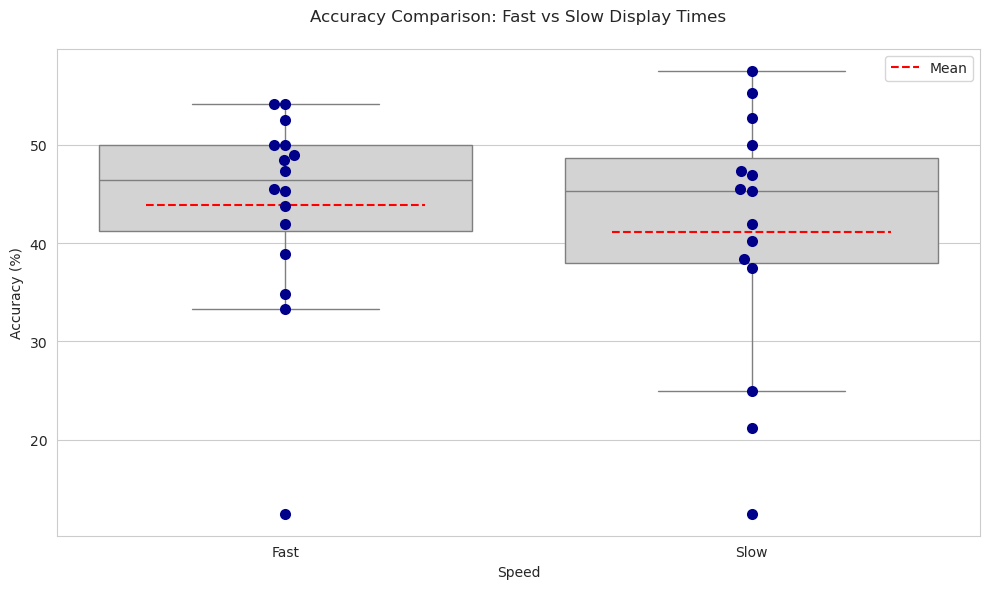

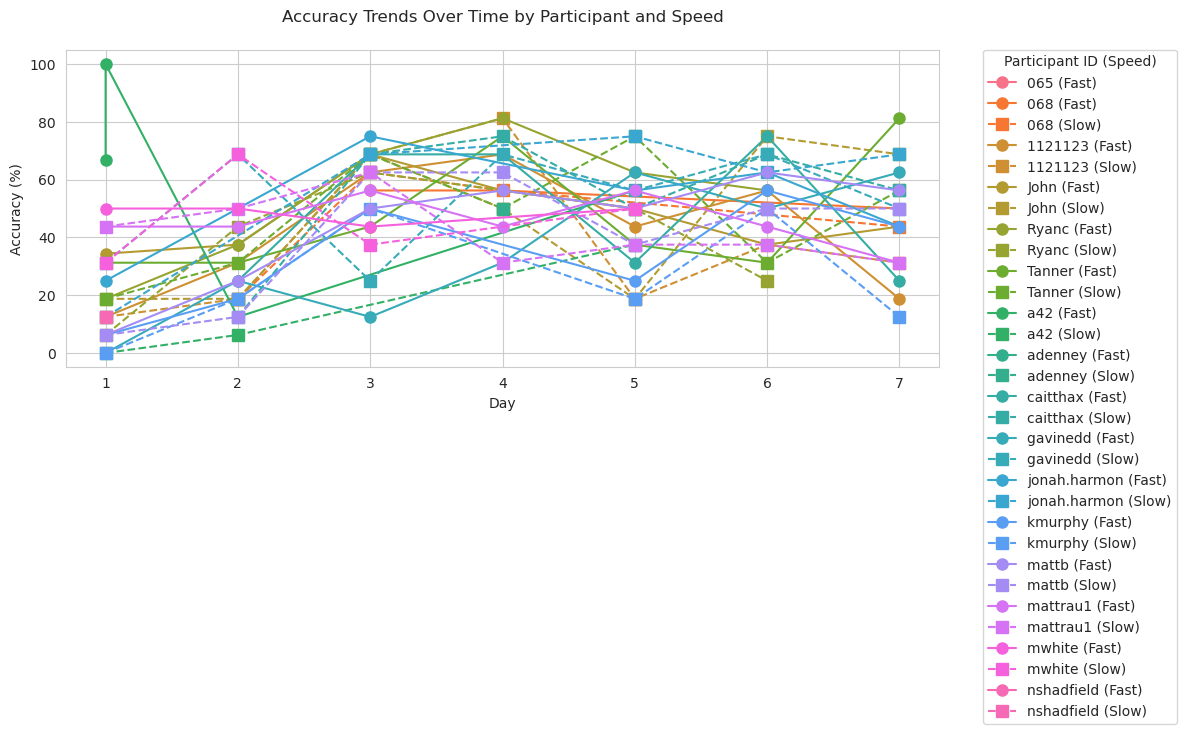

In [31]:
# Calculate statistics for all participants
participant_stats = calculate_participant_stats(results)

# Create visualizations
create_comparison_visualization(participant_stats)
plt.show()

create_accuracy_trend_visualization(results)
plt.show()

In [32]:
def remap_user_ids(df: pd.DataFrame, 
                   id_column: str,
                   mapping_dict: dict,
                   verbose: bool = True) -> pd.DataFrame:
    """
    Remap user IDs in a DataFrame based on a provided mapping dictionary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing user IDs to be remapped
    id_column : str
        The name of the column containing user IDs
    mapping_dict : dict
        Dictionary mapping incorrect user IDs to their correct versions
        e.g., {'old_id1': 'new_id1', 'old_id2': 'new_id2'}
    verbose : bool, default=True
        If True, prints summary of changes made
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with remapped user IDs
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Keep track of changes for reporting
    changes = {}
    
    # Apply the mapping
    for old_id, new_id in mapping_dict.items():
        mask = df_clean[id_column] == old_id
        count = mask.sum()
        if count > 0:
            df_clean.loc[mask, id_column] = new_id
            changes[old_id] = {'new_id': new_id, 'count': count}
    
    # Print summary if verbose is True
    if verbose and changes:
        print("\nUser ID Remapping Summary:")
        print("-" * 50)
        for old_id, info in changes.items():
            print(f"Renamed {info['count']} instances of '{old_id}' to '{info['new_id']}'")
        print(f"\nUnique user IDs after remapping: {df_clean[id_column].nunique()}")
    
    return df_clean


id_mapping = {
    '065': '068'
}

# Apply the remapping
results_clean = remap_user_ids(results, 
                             id_column='user_id', 
                             mapping_dict=id_mapping)

# Optional: Verify the changes
print("\nUnique user IDs in cleaned dataset:")
print(sorted(results_clean['user_id'].unique()))


User ID Remapping Summary:
--------------------------------------------------
Renamed 16 instances of '065' to '068'

Unique user IDs after remapping: 15

Unique user IDs in cleaned dataset:
['068', '1121123', 'John', 'Ryanc', 'Tanner', 'a42', 'adenney', 'caitthax', 'gavinedd', 'jonah.harmon', 'kmurphy', 'mattb', 'mattrau1', 'mwhite', 'nshadfield']


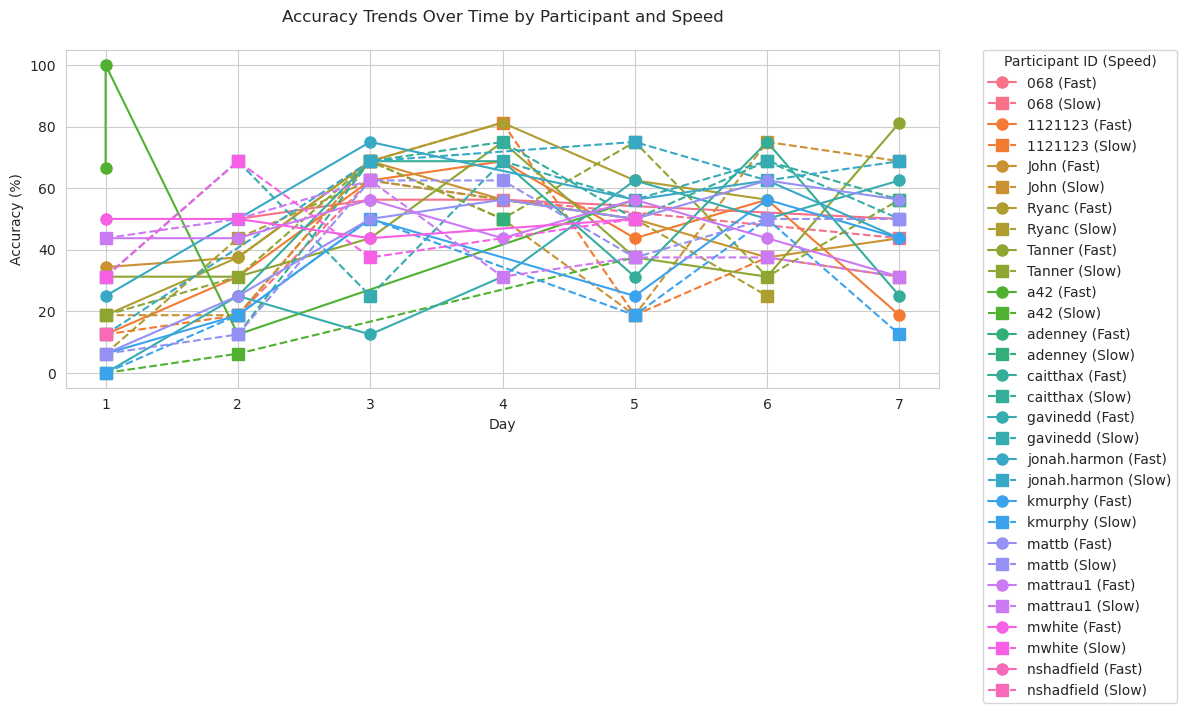

In [33]:
create_accuracy_trend_visualization(results_clean)
plt.show()

In [34]:
# clean_data_sample = results_clean.sample(100)
# clean_data_sample.to_csv('../results/clean_data_sample.csv', index=False)

In [35]:
import pandas as pd
from typing import Dict, Tuple

def identify_duplicate_trials(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify cases where users answered the same question multiple times in a quiz on the same day.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing duplicate trial entries
    """
    # Count occurrences of each question by each user in each quiz
    trial_counts = df.groupby(['user_id', 'day', 'quiz_id', 'image_index']).size().reset_index(name='attempts')
    
    # Filter for cases with multiple attempts
    duplicates = trial_counts[trial_counts['attempts'] > 1]
    
    if len(duplicates) > 0:
        print(f"\nFound {len(duplicates)} instances of duplicate trial attempts:")
        for _, row in duplicates.iterrows():
            print(f"User {row['user_id']} attempted question {row['image_index']} "
                  f"in quiz {row['quiz_id']} on day {row['day']} {row['attempts']} times")
    
    return duplicates

def identify_incomplete_quizzes(df: pd.DataFrame, expected_trials: int) -> pd.DataFrame:
    """
    Identify quizzes where users didn't complete all trials.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int
        Expected number of trials per quiz
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing incomplete quiz information
    """
    # Count trials per quiz for each user
    trial_counts = df.groupby(['user_id', 'day', 'quiz_id']).agg(
        unique_trials=('image_index', 'nunique'),
        total_trials=('image_index', 'count')
    ).reset_index()
    
    # Identify incomplete quizzes or quizzes with duplicate trials
    incomplete = trial_counts[
        (trial_counts['unique_trials'] != expected_trials) | 
        (trial_counts['total_trials'] != expected_trials)
    ]
    
    if len(incomplete) > 0:
        print(f"\nFound {len(incomplete)} problematic quizzes:")
        for _, row in incomplete.iterrows():
            if row['unique_trials'] != row['total_trials']:
                print(f"User {row['user_id']} quiz {row['quiz_id']} day {row['day']}: "
                      f"{row['unique_trials']} unique trials, {row['total_trials']} total trials "
                      f"(indicates duplicate questions)")
            else:
                print(f"User {row['user_id']} quiz {row['quiz_id']} day {row['day']}: "
                      f"completed {row['unique_trials']}/{expected_trials} trials")
    
    return incomplete

def check_data_quality(df: pd.DataFrame, expected_trials: int = 48) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run all data quality checks and return results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int, default=48
        Expected number of trials per quiz
    
    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        Duplicate trials DataFrame, Incomplete quizzes DataFrame
    """
    print(f"Running data quality checks (expected {expected_trials} trials per quiz)...")
    
    duplicates = identify_duplicate_trials(df)
    incomplete = identify_incomplete_quizzes(df, expected_trials)
    
    # Get detailed information about specific cases
    if len(duplicates) > 0:
        print("\nDetailed information for duplicate trials:")
        for _, dup in duplicates.iterrows():
            relevant_trials = df[
                (df['user_id'] == dup['user_id']) & 
                (df['day'] == dup['day']) & 
                (df['quiz_id'] == dup['quiz_id']) &
                (df['image_index'] == dup['image_index'])
            ]
            print(f"\nDetailed trials for duplicate question {dup['image_index']} "
                  f"by {dup['user_id']} on day {dup['day']} quiz {dup['quiz_id']}:")
            print(relevant_trials[['timestamp', 'image_index', 'user_answer', 'is_correct']].sort_values('timestamp'))
    
    return duplicates, incomplete

# Example usage
# Check with default 48 trials
# duplicates, incomplete = check_data_quality(results)

# Or specify a different number of expected trials
duplicates, incomplete = check_data_quality(results_clean, expected_trials=49)

Running data quality checks (expected 49 trials per quiz)...

Found 33 instances of duplicate trial attempts:
User John attempted question 0 in quiz 0 on day 1 2 times
User John attempted question 1 in quiz 0 on day 1 2 times
User John attempted question 2 in quiz 0 on day 1 2 times
User John attempted question 3 in quiz 0 on day 1 2 times
User John attempted question 4 in quiz 0 on day 1 2 times
User John attempted question 5 in quiz 0 on day 1 2 times
User John attempted question 6 in quiz 0 on day 1 2 times
User John attempted question 7 in quiz 0 on day 1 2 times
User John attempted question 8 in quiz 0 on day 1 2 times
User John attempted question 9 in quiz 0 on day 1 2 times
User John attempted question 10 in quiz 0 on day 1 2 times
User John attempted question 11 in quiz 0 on day 1 2 times
User John attempted question 12 in quiz 0 on day 1 2 times
User John attempted question 13 in quiz 0 on day 1 2 times
User John attempted question 14 in quiz 0 on day 1 2 times
User John attem

In [36]:
def remove_duplicate_trials(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Remove duplicate trials from the dataset, keeping only the first instance.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints summary of removed duplicates
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame with duplicates removed
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Sort by timestamp to ensure we keep the first instance
    df_clean = df_clean.sort_values('timestamp')
    
    # Count initial trials
    initial_count = len(df_clean)
    
    # Drop duplicates based on user_id, day, quiz_id, and image_index
    df_clean = df_clean.drop_duplicates(
        subset=['user_id', 'day', 'quiz_id', 'image_index'],
        keep='first'
    )
    
    # Count removed trials
    removed_count = initial_count - len(df_clean)
    
    if verbose and removed_count > 0:
        print(f"\nRemoved {removed_count} duplicate trials:")
        print(f"Initial trial count: {initial_count}")
        print(f"Final trial count: {len(df_clean)}")
        
        # Get counts by user
        user_counts = df.groupby('user_id').size() - df_clean.groupby('user_id').size()
        users_with_duplicates = user_counts[user_counts > 0]
        
        print("\nDuplicates removed by user:")
        for user, count in users_with_duplicates.items():
            print(f"{user}: {count} duplicate trials removed")
    
    return df_clean

def clean_and_validate_data(df: pd.DataFrame, expected_trials: int = 48) -> pd.DataFrame:
    """
    Clean data by removing duplicates and validate the results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int, default=48
        Expected number of trials per quiz
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame
    """
    print("Starting data cleaning process...")
    
    # Remove duplicates
    df_clean = remove_duplicate_trials(df)
    
    # Validate results
    print("\nValidating cleaned data...")
    duplicates, incomplete = check_data_quality(df_clean, expected_trials)
    
    if len(duplicates) == 0:
        print("\nAll duplicates successfully removed!")
    else:
        print("\nWarning: Some duplicates remain after cleaning!")
    
    # Check if any quizzes are now incomplete due to duplicate removal
    if len(incomplete) > 0:
        print("\nNote: Some quizzes are incomplete after duplicate removal.")
        print("You may want to handle these cases separately.")
    
    return df_clean

# Example usage
# Clean the data
results_drop_dups = clean_and_validate_data(results_clean, expected_trials=50)

# Optional: Compare trial counts before and after cleaning
print("\nTrial counts by user (before cleaning):")
print(results.groupby('user_id').size())
print("\nTrial counts by user (after cleaning):")
print(results_drop_dups.groupby('user_id').size())

Starting data cleaning process...

Removed 34 duplicate trials:
Initial trial count: 2485
Final trial count: 2451

Duplicates removed by user:
John: 16 duplicate trials removed
a42: 2 duplicate trials removed
nshadfield: 16 duplicate trials removed

Validating cleaned data...
Running data quality checks (expected 50 trials per quiz)...

Found 156 problematic quizzes:
User 068 quiz 4 day 2: completed 16/50 trials
User 068 quiz 7 day 2: completed 16/50 trials
User 068 quiz 8 day 3: completed 16/50 trials
User 068 quiz 9 day 3: completed 16/50 trials
User 068 quiz 12 day 4: completed 16/50 trials
User 068 quiz 13 day 4: completed 16/50 trials
User 068 quiz 24 day 7: completed 16/50 trials
User 068 quiz 25 day 7: completed 16/50 trials
User 1121123 quiz 0 day 1: completed 16/50 trials
User 1121123 quiz 1 day 1: completed 16/50 trials
User 1121123 quiz 4 day 2: completed 16/50 trials
User 1121123 quiz 5 day 2: completed 16/50 trials
User 1121123 quiz 8 day 3: completed 16/50 trials
User 112

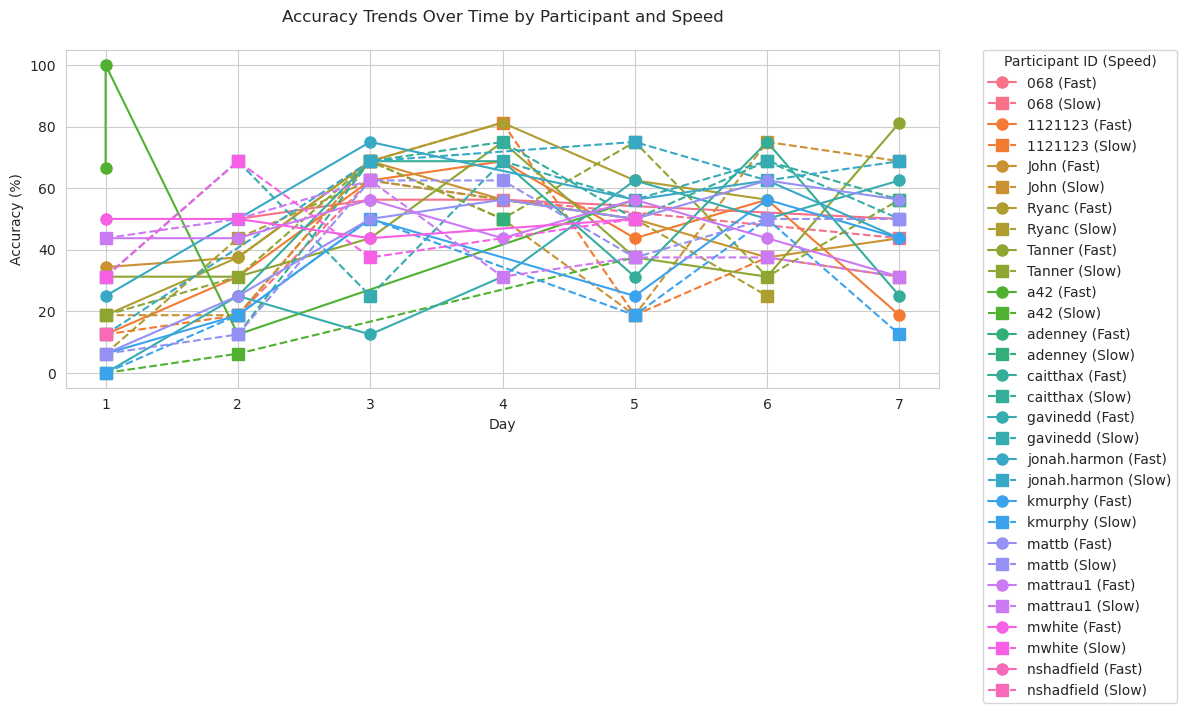

In [37]:
create_accuracy_trend_visualization(results_clean)
plt.show()

In [38]:
# create_accuracy_trend_visualization(results_drop_dups, users_to_include=['HRB'])

In [39]:
def fix_and_renumber_quizzes(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Fix quiz day assignments and renumber quizzes based on day and group.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints details of corrections
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with corrected day assignments and renumbered quizzes
    """
    df_fixed = df.copy()
    
    def get_group_num(speed_group):
        return int(speed_group.split('Group ')[1][0])
    
    # Add group number column
    df_fixed['group_num'] = df_fixed['speed_group'].apply(get_group_num)
    
    # Process each user separately
    for user in df_fixed['user_id'].unique():
        if verbose:
            print(f"\nProcessing user: {user}")
            
        user_mask = df_fixed['user_id'] == user
        user_data = df_fixed[user_mask]
        
        # First, identify and fix day assignments
        problematic_days = user_data.groupby('day').agg({
            'quiz_id': 'nunique',
            'group_num': 'nunique'
        }).reset_index()
        
        # Find days with too many quizzes
        for _, row in problematic_days.iterrows():
            day = row['day']
            day_mask = user_mask & (df_fixed['day'] == day)
            day_data = df_fixed[day_mask]
            
            # Sort quizzes by timestamp to maintain order
            quizzes = day_data.groupby('quiz_id')['timestamp'].min().sort_values()
            quiz_list = quizzes.index.tolist()
            
            if len(quiz_list) > 2:
                if verbose:
                    print(f"Day {day}: Found {len(quiz_list)} quizzes: {quiz_list}")
                
                # Move excess quizzes to next day
                for i, quiz_id in enumerate(quiz_list[2:], start=2):
                    new_day = day + 1
                    quiz_mask = day_mask & (df_fixed['quiz_id'] == quiz_id)
                    df_fixed.loc[quiz_mask, 'day'] = new_day
                    if verbose:
                        print(f"Moving quiz {quiz_id} to day {new_day}")
        
        # Now renumber all quizzes based on final day assignments
        for day in sorted(df_fixed[user_mask]['day'].unique()):
            day_mask = user_mask & (df_fixed['day'] == day)
            day_data = df_fixed[day_mask]
            
            for group in sorted(day_data['group_num'].unique()):
                group_mask = day_mask & (df_fixed['group_num'] == group)
                group_data = df_fixed[group_mask]
                
                # Get quizzes for this day/group
                quizzes = sorted(group_data['quiz_id'].unique())
                
                # Calculate new quiz numbers
                base_quiz_num = (day - 1) * 4
                if group == 1:
                    new_numbers = [base_quiz_num, base_quiz_num + 1]
                else:  # group == 2
                    new_numbers = [base_quiz_num + 2, base_quiz_num + 3]
                
                # Apply new numbers
                for old_id, new_id in zip(quizzes, new_numbers[:len(quizzes)]):
                    quiz_mask = group_mask & (df_fixed['quiz_id'] == old_id)
                    if verbose:
                        print(f"Day {day} Group {group}: Remapping quiz {old_id} to {new_id}")
                    df_fixed.loc[quiz_mask, 'quiz_id'] = new_id
    
    # Remove temporary group number column
    df_fixed = df_fixed.drop('group_num', axis=1)
    
    return df_fixed

# Example usage
results_fixed = fix_and_renumber_quizzes(results_clean)

# Verify the changes
def verify_quiz_assignments(df: pd.DataFrame):
    """Print summary of quiz assignments per user per day."""
    for user in df['user_id'].unique():
        user_data = df[df['user_id'] == user]
        quiz_summary = user_data.groupby(['day'])[['quiz_id', 'speed_group']].agg({
            'quiz_id': ['count', 'unique'],
            'speed_group': 'unique'
        }).reset_index()
        quiz_summary.columns = ['day', 'total_trials', 'unique_quizzes', 'speeds']
        print(f"\nUser: {user}")
        print(quiz_summary)

# Run verification
verify_quiz_assignments(results_fixed)


Processing user: mattrau1
Day 1 Group 2: Remapping quiz 2 to 2
Day 1 Group 2: Remapping quiz 3 to 3
Day 2 Group 2: Remapping quiz 6 to 6
Day 2 Group 2: Remapping quiz 7 to 7
Day 3 Group 2: Remapping quiz 10 to 10
Day 3 Group 2: Remapping quiz 11 to 11
Day 4 Group 2: Remapping quiz 14 to 14
Day 4 Group 2: Remapping quiz 15 to 15
Day 5 Group 2: Remapping quiz 18 to 18
Day 5 Group 2: Remapping quiz 19 to 19
Day 6 Group 2: Remapping quiz 22 to 22
Day 6 Group 2: Remapping quiz 23 to 23
Day 7 Group 1: Remapping quiz 24 to 24
Day 7 Group 2: Remapping quiz 27 to 26

Processing user: jonah.harmon
Day 1 Group 1: Remapping quiz 0 to 0
Day 1 Group 1: Remapping quiz 1 to 1
Day 3 Group 1: Remapping quiz 8 to 8
Day 3 Group 1: Remapping quiz 9 to 9
Day 5 Group 1: Remapping quiz 16 to 16
Day 5 Group 1: Remapping quiz 17 to 17
Day 6 Group 1: Remapping quiz 20 to 20
Day 6 Group 1: Remapping quiz 21 to 21
Day 7 Group 1: Remapping quiz 24 to 24
Day 7 Group 1: Remapping quiz 25 to 25

Processing user: mwhi

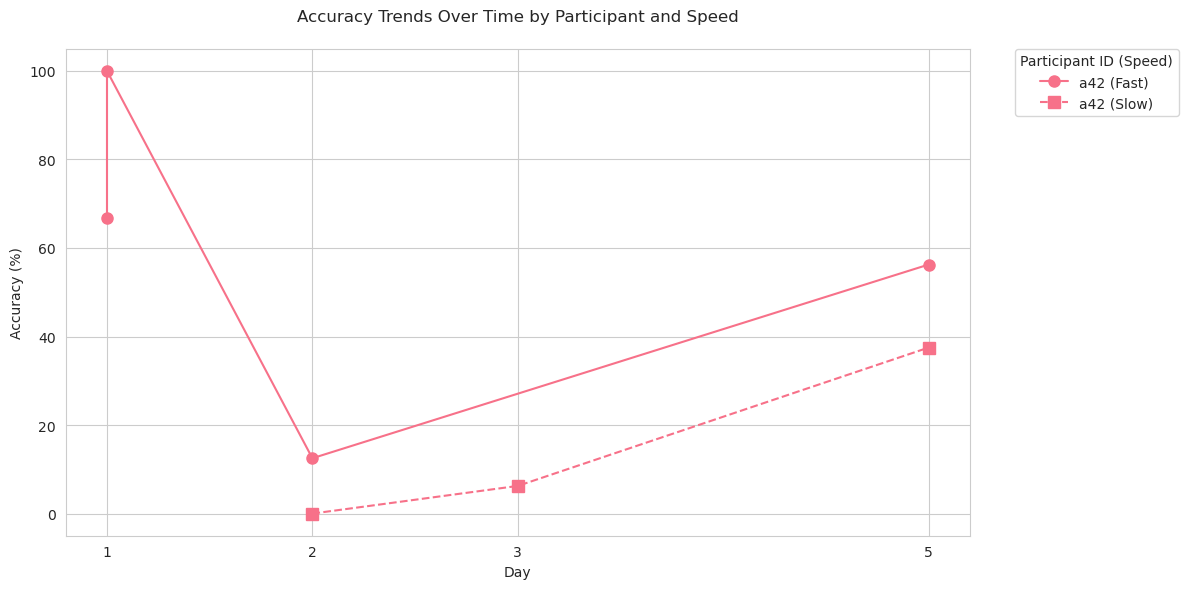

In [40]:
create_accuracy_trend_visualization(results_fixed, users_to_include=['a42'])

In [41]:
def remove_users(df: pd.DataFrame, users_to_remove: list, verbose: bool = True) -> pd.DataFrame:
    """
    Remove specified users from the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    users_to_remove : list
        List of user IDs to remove from the dataset
    verbose : bool, default=True
        If True, prints summary of removed data
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with specified users removed
    """
    # Create a copy to avoid modifying the original DataFrame
    df_filtered = df.copy()
    
    # Store initial counts
    initial_users = df_filtered['user_id'].nunique()
    initial_trials = len(df_filtered)
    
    # Remove specified users
    df_filtered = df_filtered[~df_filtered['user_id'].isin(users_to_remove)]
    
    if verbose:
        # Calculate removed counts
        removed_users = initial_users - df_filtered['user_id'].nunique()
        removed_trials = initial_trials - len(df_filtered)
        
        print(f"\nRemoved {removed_users} users and {removed_trials} trials:")
        for user in users_to_remove:
            user_trials = len(df[df['user_id'] == user])
            print(f"- {user}: {user_trials} trials")
            
        print(f"\nRemaining users: {sorted(df_filtered['user_id'].unique())}")
        print(f"Remaining trials: {len(df_filtered)}")
    
    return df_filtered

# Example usage
users_to_remove = ['a42', 'adenney']
results_filtered = remove_users(results_fixed, users_to_remove)

# Verify the filtering
def verify_filtered_data(df: pd.DataFrame):
    """Print summary of remaining data."""
    print("\nData summary after filtering:")
    print(f"Total users: {df['user_id'].nunique()}")
    print(f"Total trials: {len(df)}")
    print("\nTrials per user:")
    print(df.groupby('user_id').size())

# Run verification
verify_filtered_data(results_fixed)


Removed 2 users and 101 trials:
- a42: 69 trials
- adenney: 32 trials

Remaining users: ['068', '1121123', 'John', 'Ryanc', 'Tanner', 'caitthax', 'gavinedd', 'jonah.harmon', 'kmurphy', 'mattb', 'mattrau1', 'mwhite', 'nshadfield']
Remaining trials: 2384

Data summary after filtering:
Total users: 15
Total trials: 2485

Trials per user:
user_id
068             128
1121123         224
John            240
Ryanc           176
Tanner          224
a42              69
adenney          32
caitthax        192
gavinedd        224
jonah.harmon    160
kmurphy         192
mattb           224
mattrau1        224
mwhite          128
nshadfield       48
dtype: int64


In [42]:
def standardize_user_groups(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Standardize user groups by identifying each user's majority group and
    correcting any outlier group assignments while preserving fast/slow designation.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints details of corrections
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standardized group assignments
    """
    df_fixed = df.copy()
    
    # Function to extract just the group number
    def get_group_num(speed_group):
        return int(speed_group.split('Group ')[1][0])
    
    # Function to extract just the speed designation
    def get_speed(speed_group):
        return 'Fast' if 'Fast' in speed_group else 'Slow'
    
    # Process each user separately
    for user in df_fixed['user_id'].unique():
        user_data = df_fixed[df_fixed['user_id'] == user]
        
        # Get group counts for this user
        group_counts = user_data['speed_group'].apply(get_group_num).value_counts()
        majority_group = group_counts.index[0]
        
        if len(group_counts) > 1 and verbose:
            print(f"\nProcessing user: {user}")
            print(f"Group counts: {group_counts.to_dict()}")
            print(f"Majority group: Group {majority_group}")
        
        # Check for mismatched groups
        for idx, row in user_data.iterrows():
            current_group = get_group_num(row['speed_group'])
            current_speed = get_speed(row['speed_group'])
            
            if current_group != majority_group:
                # Create new speed_group string
                new_speed_group = f"Group {majority_group} - {current_speed}"
                
                if verbose:
                    print(f"Changing {row['speed_group']} to {new_speed_group} "
                          f"for quiz {row['quiz_id']} on day {row['day']}")
                
                df_fixed.loc[idx, 'speed_group'] = new_speed_group
    
    # Verify changes
    if verbose:
        print("\nFinal group distribution by user:")
        for user in df_fixed['user_id'].unique():
            user_groups = df_fixed[df_fixed['user_id'] == user]['speed_group'].unique()
            print(f"\n{user}: {sorted(user_groups)}")
    
    return df_fixed

# Example usage
results_standardized = standardize_user_groups(results_filtered)

# Verification function
def verify_group_assignments(df: pd.DataFrame):
    """Print summary of group assignments per user."""
    for user in df['user_id'].unique():
        user_data = df[df['user_id'] == user]
        print(f"\nUser: {user}")
        print("Group distribution:")
        print(user_data['speed_group'].value_counts())
        print("\nUnique speed_group values:")
        print(sorted(user_data['speed_group'].unique()))

# Run verification
verify_group_assignments(results_standardized)


Processing user: mattrau1
Group counts: {2: 208, 1: 16}
Majority group: Group 2
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - Fast for quiz 24 on day 7
Changing Group 1 - Fast to Group 2 - 

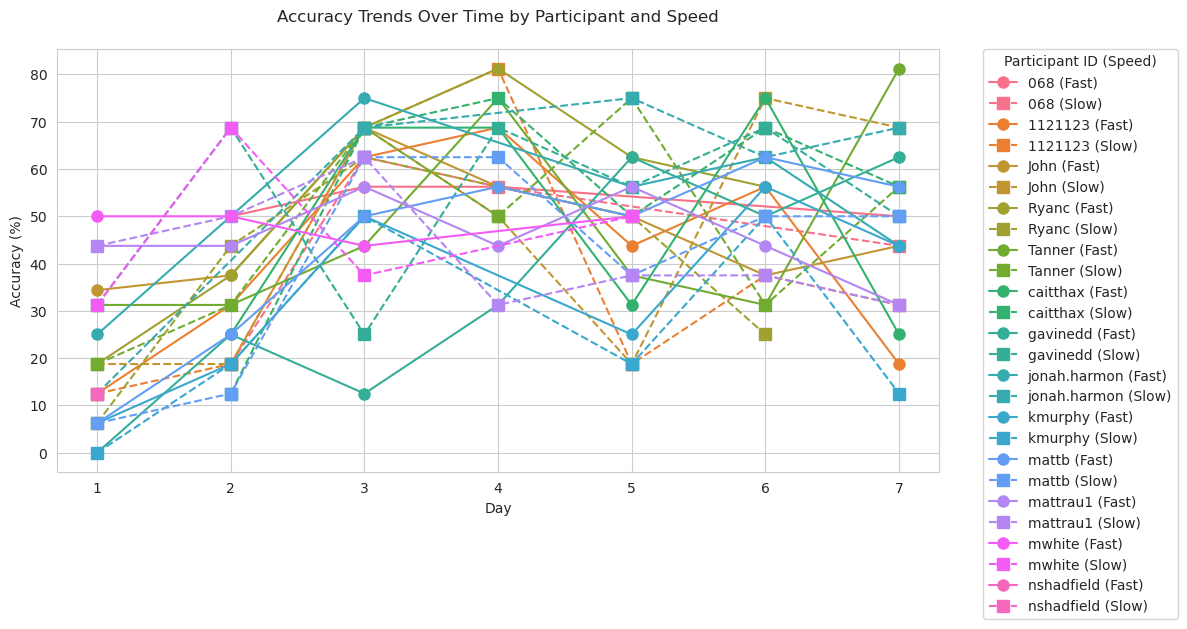

In [43]:
create_accuracy_trend_visualization(results_standardized)

In [44]:
results_standardized.to_csv('../results/cleaned_data.csv', index=False)